# Notes

# Imports

In [3]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import time
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial import distance
import seaborn as sns
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
sys.path.append('./lib/')

from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL
from kinematics import compute_signed_pec_z_difference, compute_phi_dot_from_raw_trajectories, compute_coordinate_origin_z
from post_processing import contiguous_regions
from windowed_prob_utils import return_overlapping_windows_for_timeframes, compute_windowed_distribution_array_from_1D_tseries
from windowed_prob_utils import get_fightbout_rectangle_info


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the tracking data

In [4]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]

# compute the $D_{PP}, \theta_{W}, \theta_{L}$ vars

In [5]:
# ---- generate the state variables for all exps ---- #


t0 = time.perf_counter()

exp_dpps = []
exp_tetWs = []
exp_tetLs = []

for ii, expName in enumerate(expNames):
    print(expName)
    
    smooth_traj = smooth_trajectories[ii]
    winIdx = winner_idxs[ii]
    losIdx = loser_idxs[ii]
    
    dpp_ts = compute_pec_pec_distance(smooth_traj)
    tetW_ts, tetL_ts = compute_thetaW_and_thetaL(smooth_traj, winIdx, losIdx)
    
    # ---- record ---- #
    
    exp_dpps.append(dpp_ts)
    exp_tetWs.append(tetW_ts)
    exp_tetLs.append(tetL_ts)
    
tE = time.perf_counter()
print()
print('finished: {0} s'.format(tE-t0))

FishTank20200127_143538
FishTank20200129_140656
FishTank20200130_153857
FishTank20200130_181614
FishTank20200207_161445
FishTank20200213_154940
FishTank20200214_153519
FishTank20200217_160052
FishTank20200218_153008
FishTank20200316_163320
FishTank20200327_154737
FishTank20200330_161100
FishTank20200331_162136
FishTank20200520_152810
FishTank20200521_154541
FishTank20200525_161602
FishTank20200526_160100


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:24: RuntimeWarning: invalid value encountered in true_divide
  vec_ts = vec_ts / row_norms[:, np.newaxis]


FishTank20200527_152401
FishTank20200824_151740
FishTank20200828_155504
FishTank20200902_160124
FishTank20200903_160946

finished: 7.572782640345395 s


# Panel A

## preparing data

In [39]:
# ---  time bin params ---- #
window_size=6000   # the window width [frames]
window_step=100    # the step forward in time between windows [frames]

# --- the bins for the variables --- #
dpp_bins = np.linspace(0, 30, 300)
tet_bins = np.linspace(-np.pi, np.pi, 300)

In [40]:
expIdx = 2
expName = expNames[expIdx]

dpp = exp_dpps[expIdx]
tetW = exp_tetWs[expIdx]
tetL = exp_tetLs[expIdx]

expNfs = dpp.shape[0]


# get the fight-bout info for experiment
exp_fight_bout_info_arr = fight_bout_info_noDurThresh[fight_bout_info_noDurThresh[:,0]==expIdx][:,1:3]
# turn the array over bouts into a list over bouts
fight_bout_info_list = [exp_fight_bout_info_arr[i] for i in range(exp_fight_bout_info_arr.shape[0])]


# get the time-windows 
exp_time_wins = return_overlapping_windows_for_timeframes(expNfs,
                                                          window_size=window_size,
                                                          window_step=window_step)

# compute the windowed distributions
dpp_heatmap = compute_windowed_distribution_array_from_1D_tseries(dpp, 
                                                                  exp_time_wins,
                                                                  dpp_bins)
tetW_heatmap = compute_windowed_distribution_array_from_1D_tseries(tetW, 
                                                                   exp_time_wins,
                                                                   tet_bins)
tetL_heatmap = compute_windowed_distribution_array_from_1D_tseries(tetL, 
                                                                   exp_time_wins,
                                                                   tet_bins)



In [41]:
np.max(dpp_heatmap)

557.0

In [42]:
np.max(tetW_heatmap)

607.0

In [43]:
np.max(tetL_heatmap)

461.0

In [44]:
tetL_heatmap.shape

(299, 4960)

In [45]:
np.max(dpp_heatmap) / 6000

0.09283333333333334

In [46]:
np.max(tetW_heatmap) / 6000

0.10116666666666667

In [47]:
np.max(tetL_heatmap) / 6000

0.07683333333333334

## rough plot

In [48]:
def make_dpp_tetW_tetL_windowed_dist_figure_rough(expName, dpp_win_dist, tetW_win_dist, tetL_win_dist, dpp_bins, tet_bins, exp_time_wins, conclusive_winner=True,
                                            dpp_vmax=150, tet_vmax=150, num_xticks=10, cmap='Blues', fps=100, use_cbar=False, fight_bout_info_list=None):
    ''' Return the fig, axs values for a figure containing the windowed distributions of dpp,tetW,tetL for each experiment.
    '''
    
    plt.ioff()
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,6), sharex=False)
    fig.suptitle(f"{expName}", fontsize=14)
    
    
    # prepare the drawing of fight-bout regions
    if fight_bout_info_list is not None:
        do_draw_fight_boundaries = True
        # count the number of fights
        numFightBouts = len(fight_bout_info_list)
    

    # ----------------------- dpp ------------------------------#
    ax = axs[0]
    ts_windowed_data = dpp_win_dist
    data_bins = dpp_bins
    panel_title = r'$D_{PP}$ [cm]'

    # some params of the binning
    bin_min = data_bins[0]
    bin_max = data_bins[-1]
    bin_size = np.diff(data_bins)[0]

    # make the heatmap
    heatmap = sns.heatmap(ts_windowed_data, vmax=dpp_vmax, cbar=use_cbar, cmap=cmap, ax=ax);
    if use_cbar == True:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([])
        cbar.set_ticklabels([])

    # prepare the labels
    ax.set_title('')
    ax.set_ylabel(panel_title, fontsize=12)

    # prepare the xticks
    xticks = np.linspace(0, 4800, 9).astype(int)
    ax.set_xticks(xticks);
    xtick_labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80']
    ax.set_xticklabels([]);

    # prepare the yticks
    yticks = [0, len(data_bins)]
    ytick_labels = [int(np.round(bin_min)), int(np.round(bin_max))][::-1]
    ax.set_yticks(yticks);
    ax.set_yticklabels(ytick_labels, rotation=0);

    # make frame visible
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # make the frames thicker
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.xaxis.set_tick_params(width=2, length=8)
    ax.yaxis.set_tick_params(width=2, length=8)
    
    
    # draw the fight-bouts if you want to
    if do_draw_fight_boundaries:
        for boutIdx in range(numFightBouts):
            fight_f0, fight_fE = fight_bout_info_list[boutIdx]
            left, bottom, width, height = get_fightbout_rectangle_info(fight_f0, fight_fE, 
                                                                       exp_time_wins, data_bins)
            rect=mpatches.Rectangle((left,bottom),width,height,
                                    fill=False,
                                    alpha=1,
                                    color="black",
                                    linestyle='--')
            ax.add_patch(rect)




    # ----------------------- tet1 ------------------------------#
    ax = axs[1]
    ts_windowed_data = tetW_win_dist
    data_bins = tet_bins
    if conclusive_winner:
        panel_title = r'$\theta_{W}$ [rad]'
    else:
        panel_title = r'$\theta_{?}$ [rad]'

    # some params of the binning
    bin_min = data_bins[0]
    bin_max = data_bins[-1]
    bin_size = np.diff(data_bins)[0]

    # make the heatmap
    heatmap = sns.heatmap(ts_windowed_data, vmax=tet_vmax, cbar=use_cbar, cmap=cmap, ax=ax);
    if use_cbar == True:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([])
        cbar.set_ticklabels([])

    # prepare the labels
    ax.set_title('')
    ax.set_ylabel(panel_title, fontsize=12)

    # prepare the xticks
    xticks = np.linspace(0, 4800, 9).astype(int)
    ax.set_xticks(xticks);
    xtick_labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80']
    ax.set_xticklabels([]);

    # prepare the yticks
    yticks = [0, len(data_bins)/2, len(data_bins)]
    ytick_labels = [r'$-\pi$', '0', r'$\pi$'][::-1]
    ax.set_yticks(yticks);
    ax.set_yticklabels(ytick_labels, rotation=0);

    # make frame visible
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # make the frames thicker
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.xaxis.set_tick_params(width=2, length=8)
    ax.yaxis.set_tick_params(width=2, length=8) 
    
    
    # draw the fight-bouts if you want to
    if do_draw_fight_boundaries:
        for boutIdx in range(numFightBouts):
            fight_f0, fight_fE = fight_bout_info_list[boutIdx]
            left, bottom, width, height = get_fightbout_rectangle_info(fight_f0, fight_fE, 
                                                                       exp_time_wins, data_bins)
            rect=mpatches.Rectangle((left,bottom),width,height,
                                    fill=False,
                                    alpha=1,
                                    color="black",
                                    linestyle='--')
            ax.add_patch(rect)




    # ----------------------- tet2 ------------------------------#
    ax = axs[2]
    ts_windowed_data = tetL_win_dist
    data_bins = tet_bins
    if conclusive_winner:
        panel_title = r'$\theta_{L}$ [rad]'
    else:
        panel_title = r'$\theta_{?}$ [rad]'

    # some params of the binning
    bin_min = data_bins[0]
    bin_max = data_bins[-1]
    bin_size = np.diff(data_bins)[0]

    # make the heatmap
    heatmap = sns.heatmap(ts_windowed_data, vmax=tet_vmax, cbar=use_cbar, cmap=cmap, ax=ax);
    if use_cbar == True:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([])
        cbar.set_ticklabels([])

    # prepare the labels
    ax.set_title('')
    ax.set_ylabel(panel_title, fontsize=12)
    ax.set_xlabel('time [min]', fontsize=12)

    # prepare the xticks
    xticks = np.linspace(0, 4800, 9).astype(int)
    ax.set_xticks(xticks);
    xtick_labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80']
    ax.set_xticklabels(xtick_labels);

    # prepare the yticks
    yticks = [0, len(data_bins)/2, len(data_bins)]
    ytick_labels = [r'$-\pi$', '0', r'$\pi$'][::-1]
    ax.set_yticks(yticks);
    ax.set_yticklabels(ytick_labels, rotation=0);

    # make frame visible
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # make the frames thicker
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.xaxis.set_tick_params(width=2, length=8)
    ax.yaxis.set_tick_params(width=2, length=8) 
    
    
    # draw the fight-bouts if you want to
    if do_draw_fight_boundaries:
        for boutIdx in range(numFightBouts):
            fight_f0, fight_fE = fight_bout_info_list[boutIdx]
            left, bottom, width, height = get_fightbout_rectangle_info(fight_f0, fight_fE, 
                                                                       exp_time_wins, data_bins)
            rect=mpatches.Rectangle((left,bottom),width,height,
                                    fill=False,
                                    alpha=1,
                                    color="black",
                                    linestyle='--')
            ax.add_patch(rect)


    # ---------------------------------------------------------------------#

    # wrap up
    fig.tight_layout()
    plt.ion()
    return fig, axs

In [386]:

figsavepath = '/home/liam/temp/image_transfer/testaaa.png'

fig, axs =  make_dpp_tetW_tetL_windowed_dist_figure_rough(expName, 
                                                    dpp_heatmap, tetW_heatmap, tetL_heatmap, 
                                                    dpp_bins, tet_bins, exp_time_wins,
                                                    conclusive_winner=True,
                                                    dpp_vmax=200, tet_vmax=120, num_xticks=10, 
                                                    cmap='Blues', fps=100, use_cbar=False, 
                                                    fight_bout_info_list=fight_bout_info_list)
# save the figure
fig.savefig(figsavepath, dpi=300, transparent=False, bbox_inches='tight', pad_inches=0.1)
print('done')

done


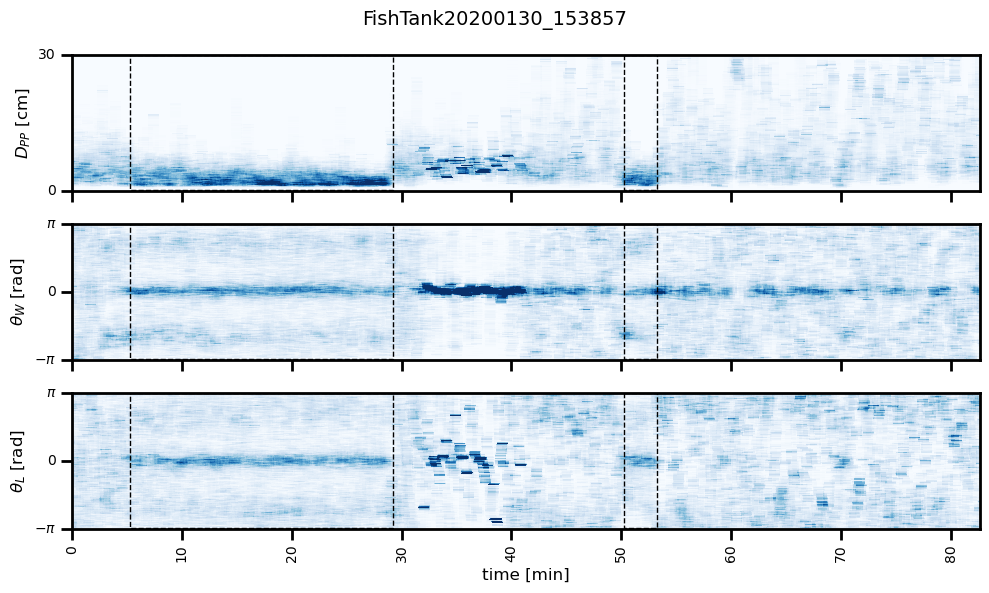

In [387]:
fig

## paper version

In [49]:
def make_dpp_tetW_tetL_windowed_dist_figure_paper(expName, dpp_win_dist, tetW_win_dist, tetL_win_dist, dpp_bins, tet_bins, exp_time_wins, conclusive_winner=True,
                                            dpp_vmax=150, tet_vmax=150, num_xticks=10, cmap='Blues', fps=100, use_cbar=False, fight_bout_info_list=None):
    ''' Return the fig, axs values for a figure containing the windowed distributions of dpp,tetW,tetL for each experiment.
    '''
    
    plt.ioff()
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(2.45,2.2), sharex=False)
    #fig.suptitle(f"{expName}", fontsize=14)
    
    
    # prepare the drawing of fight-bout regions
    if fight_bout_info_list is not None:
        do_draw_fight_boundaries = True
        # count the number of fights
        numFightBouts = len(fight_bout_info_list)
    

    # ----------------------- dpp ------------------------------#
    ax = axs[0]
    ts_windowed_data = dpp_win_dist
    data_bins = dpp_bins
    panel_title = ''

    # some params of the binning
    bin_min = data_bins[0]
    bin_max = data_bins[-1]
    bin_size = np.diff(data_bins)[0]

    # make the heatmap
    heatmap = sns.heatmap(ts_windowed_data, vmax=dpp_vmax, cbar=use_cbar, cmap=cmap, ax=ax);
    if use_cbar == True:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([])
        cbar.set_ticklabels([])

    # prepare the labels
    ax.set_title('')
    ax.set_ylabel(panel_title, fontsize=12)

    # prepare the xticks
    xticks = np.linspace(0, 4800, 9).astype(int)
    ax.set_xticks(xticks);
    xtick_labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80']
    ax.set_xticklabels([]);

    # prepare the yticks
    yticks = [0, len(data_bins)]
    ytick_labels = [int(np.round(bin_min)), int(np.round(bin_max))][::-1]
    ax.set_yticks(yticks);
    ax.set_yticklabels([], rotation=0);

    # make frame visible
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # make the frames thicker
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.7)
    ax.xaxis.set_tick_params(width=0.7, length=2)
    ax.yaxis.set_tick_params(width=0.7, length=2)
    
    
    # draw the fight-bouts if you want to
    if do_draw_fight_boundaries:
        for boutIdx in range(numFightBouts):
            fight_f0, fight_fE = fight_bout_info_list[boutIdx]
            left, bottom, width, height = get_fightbout_rectangle_info(fight_f0, fight_fE, 
                                                                       exp_time_wins, data_bins)
            rect=mpatches.Rectangle((left,bottom),width,height,
                                    fill=False,
                                    alpha=1,
                                    color="black",
                                    linestyle='--', linewidth=0.6)
            ax.add_patch(rect)




    # ----------------------- tet1 ------------------------------#
    ax = axs[1]
    ts_windowed_data = tetW_win_dist
    data_bins = tet_bins
    panel_title = ''

    # some params of the binning
    bin_min = data_bins[0]
    bin_max = data_bins[-1]
    bin_size = np.diff(data_bins)[0]

    # make the heatmap
    heatmap = sns.heatmap(ts_windowed_data, vmax=tet_vmax, cbar=use_cbar, cmap=cmap, ax=ax);
    if use_cbar == True:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([])
        cbar.set_ticklabels([])

    # prepare the labels
    ax.set_title('')
    ax.set_ylabel(panel_title, fontsize=12)

    # prepare the xticks
    xticks = np.linspace(0, 4800, 9).astype(int)
    ax.set_xticks(xticks);
    xtick_labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80']
    ax.set_xticklabels([]);

    # prepare the yticks
    yticks = [0, len(data_bins)/2, len(data_bins)]
    ytick_labels = [r'$-\pi$', '0', r'$\pi$'][::-1]
    ax.set_yticks(yticks);
    ax.set_yticklabels([], rotation=0);

    # make frame visible
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # make the frames thicker
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.7)
    ax.xaxis.set_tick_params(width=0.7, length=2)
    ax.yaxis.set_tick_params(width=0.7, length=2) 
    
    
    # draw the fight-bouts if you want to
    if do_draw_fight_boundaries:
        for boutIdx in range(numFightBouts):
            fight_f0, fight_fE = fight_bout_info_list[boutIdx]
            left, bottom, width, height = get_fightbout_rectangle_info(fight_f0, fight_fE, 
                                                                       exp_time_wins, data_bins)
            rect=mpatches.Rectangle((left,bottom),width,height,
                                    fill=False,
                                    alpha=1,
                                    color="black",
                                    linestyle='--', linewidth=0.6)
            ax.add_patch(rect)




    # ----------------------- tet2 ------------------------------#
    ax = axs[2]
    ts_windowed_data = tetL_win_dist
    data_bins = tet_bins
    panel_title = ''

    # some params of the binning
    bin_min = data_bins[0]
    bin_max = data_bins[-1]
    bin_size = np.diff(data_bins)[0]

    # make the heatmap
    heatmap = sns.heatmap(ts_windowed_data, vmax=tet_vmax, cbar=use_cbar, cmap=cmap, ax=ax);
    if use_cbar == True:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([])
        cbar.set_ticklabels([])

    # prepare the labels
    ax.set_title('')
    ax.set_ylabel(panel_title, fontsize=12)
    ax.set_xlabel('', fontsize=12)

    # prepare the xticks
    xticks = np.linspace(0, 4800, 9).astype(int)
    ax.set_xticks(xticks);
    xtick_labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80']
    ax.set_xticklabels([]);

    # prepare the yticks
    yticks = [0, len(data_bins)/2, len(data_bins)]
    ytick_labels = [r'$-\pi$', '0', r'$\pi$'][::-1]
    ax.set_yticks(yticks);
    ax.set_yticklabels([], rotation=0);

    # make frame visible
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # make the frames thicker
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.7)
    ax.xaxis.set_tick_params(width=0.7, length=2)
    ax.yaxis.set_tick_params(width=0.7, length=2) 
    
    
    # draw the fight-bouts if you want to
    if do_draw_fight_boundaries:
        for boutIdx in range(numFightBouts):
            fight_f0, fight_fE = fight_bout_info_list[boutIdx]
            left, bottom, width, height = get_fightbout_rectangle_info(fight_f0, fight_fE, 
                                                                       exp_time_wins, data_bins)
            rect=mpatches.Rectangle((left,bottom),width,height,
                                    fill=False,
                                    alpha=1,
                                    color="black",
                                    linestyle='--', linewidth=0.6)
            ax.add_patch(rect)


    # ---------------------------------------------------------------------#

    # wrap up
    fig.tight_layout()
    plt.ion()
    return fig, axs

In [50]:
# the colorbar limits, after normalizing by number of samples in a window

In [51]:
200 / 6000

0.03333333333333333

In [52]:
120 / 6000

0.02

In [53]:
figsavepath = '/home/liam/temp/image_transfer/fig3_A.png'

fig, axs =  make_dpp_tetW_tetL_windowed_dist_figure_paper(expName, 
                                                    dpp_heatmap, tetW_heatmap, tetL_heatmap, 
                                                    dpp_bins, tet_bins, exp_time_wins,
                                                    conclusive_winner=True,
                                                    dpp_vmax=200, tet_vmax=120, num_xticks=10, 
                                                    cmap='Blues', fps=100, use_cbar=False, 
                                                    fight_bout_info_list=fight_bout_info_list)
# save the figure
fig.savefig(figsavepath, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.1)
print('done')

/tmp/ipykernel_3474757/3954917224.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(2.45,2.2), sharex=False)


done


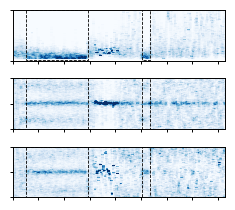

In [54]:
fig

## paper version resized

In [70]:
def make_dpp_tetW_tetL_windowed_dist_figure_paper_resized(expName, dpp_win_dist, tetW_win_dist, tetL_win_dist, dpp_bins, tet_bins, exp_time_wins, fig_width=2.45, fig_height=2.2, conclusive_winner=True,
                                            dpp_vmax=150, tet_vmax=150, num_xticks=10, cmap='Blues', fps=100, use_cbar=False, fight_bout_info_list=None):
    ''' Return the fig, axs values for a figure containing the windowed distributions of dpp,tetW,tetL for each experiment.
    '''
    
    plt.ioff()
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(fig_width, fig_height), sharex=False)
    #fig.suptitle(f"{expName}", fontsize=14)
    
    
    # prepare the drawing of fight-bout regions
    if fight_bout_info_list is not None:
        do_draw_fight_boundaries = True
        # count the number of fights
        numFightBouts = len(fight_bout_info_list)
    

    # ----------------------- dpp ------------------------------#
    ax = axs[0]
    ts_windowed_data = dpp_win_dist
    data_bins = dpp_bins
    panel_title = ''

    # some params of the binning
    bin_min = data_bins[0]
    bin_max = data_bins[-1]
    bin_size = np.diff(data_bins)[0]

    # make the heatmap
    heatmap = sns.heatmap(ts_windowed_data, vmax=dpp_vmax, cbar=use_cbar, cmap=cmap, ax=ax);
    if use_cbar == True:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([])
        cbar.set_ticklabels([])

    # prepare the labels
    ax.set_title('')
    ax.set_ylabel(panel_title, fontsize=12)

    # prepare the xticks
    xticks = np.linspace(0, 4800, 9).astype(int)
    ax.set_xticks(xticks);
    xtick_labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80']
    ax.set_xticklabels([]);

    # prepare the yticks
    yticks = [0, len(data_bins)]
    ytick_labels = [int(np.round(bin_min)), int(np.round(bin_max))][::-1]
    ax.set_yticks(yticks);
    ax.set_yticklabels([], rotation=0);

    # make frame visible
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # make the frames thicker
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.9)
    ax.xaxis.set_tick_params(width=1, length=2)
    ax.yaxis.set_tick_params(width=1, length=2)
    
    
    # draw the fight-bouts if you want to
    if do_draw_fight_boundaries:
        for boutIdx in range(numFightBouts):
            fight_f0, fight_fE = fight_bout_info_list[boutIdx]
            left, bottom, width, height = get_fightbout_rectangle_info(fight_f0, fight_fE, 
                                                                       exp_time_wins, data_bins)
            rect=mpatches.Rectangle((left,bottom),width,height,
                                    fill=False,
                                    alpha=1,
                                    color="black",
                                    linestyle='--', linewidth=0.6)
            ax.add_patch(rect)




    # ----------------------- tet1 ------------------------------#
    ax = axs[1]
    ts_windowed_data = tetW_win_dist
    data_bins = tet_bins
    panel_title = ''

    # some params of the binning
    bin_min = data_bins[0]
    bin_max = data_bins[-1]
    bin_size = np.diff(data_bins)[0]

    # make the heatmap
    heatmap = sns.heatmap(ts_windowed_data, vmax=tet_vmax, cbar=use_cbar, cmap=cmap, ax=ax);
    if use_cbar == True:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([])
        cbar.set_ticklabels([])

    # prepare the labels
    ax.set_title('')
    ax.set_ylabel(panel_title, fontsize=12)

    # prepare the xticks
    xticks = np.linspace(0, 4800, 9).astype(int)
    ax.set_xticks(xticks);
    xtick_labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80']
    ax.set_xticklabels([]);

    # prepare the yticks
    yticks = [0, len(data_bins)/2, len(data_bins)]
    ytick_labels = [r'$-\pi$', '0', r'$\pi$'][::-1]
    ax.set_yticks(yticks);
    ax.set_yticklabels([], rotation=0);

    # make frame visible
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # make the frames thicker
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.9)
    ax.xaxis.set_tick_params(width=1, length=2)
    ax.yaxis.set_tick_params(width=1, length=2) 
    
    
    # draw the fight-bouts if you want to
    if do_draw_fight_boundaries:
        for boutIdx in range(numFightBouts):
            fight_f0, fight_fE = fight_bout_info_list[boutIdx]
            left, bottom, width, height = get_fightbout_rectangle_info(fight_f0, fight_fE, 
                                                                       exp_time_wins, data_bins)
            rect=mpatches.Rectangle((left,bottom),width,height,
                                    fill=False,
                                    alpha=1,
                                    color="black",
                                    linestyle='--', linewidth=0.6)
            ax.add_patch(rect)




    # ----------------------- tet2 ------------------------------#
    ax = axs[2]
    ts_windowed_data = tetL_win_dist
    data_bins = tet_bins
    panel_title = ''

    # some params of the binning
    bin_min = data_bins[0]
    bin_max = data_bins[-1]
    bin_size = np.diff(data_bins)[0]

    # make the heatmap
    heatmap = sns.heatmap(ts_windowed_data, vmax=tet_vmax, cbar=use_cbar, cmap=cmap, ax=ax);
    if use_cbar == True:
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([])
        cbar.set_ticklabels([])

    # prepare the labels
    ax.set_title('')
    ax.set_ylabel(panel_title, fontsize=12)
    ax.set_xlabel('', fontsize=12)

    # prepare the xticks
    xticks = np.linspace(0, 4800, 9).astype(int)
    ax.set_xticks(xticks);
    xtick_labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80']
    ax.set_xticklabels([]);

    # prepare the yticks
    yticks = [0, len(data_bins)/2, len(data_bins)]
    ytick_labels = [r'$-\pi$', '0', r'$\pi$'][::-1]
    ax.set_yticks(yticks);
    ax.set_yticklabels([], rotation=0);

    # make frame visible
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # make the frames thicker
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.9)
    ax.xaxis.set_tick_params(width=1, length=2)
    ax.yaxis.set_tick_params(width=1, length=2) 
    
    
    # draw the fight-bouts if you want to
    if do_draw_fight_boundaries:
        for boutIdx in range(numFightBouts):
            fight_f0, fight_fE = fight_bout_info_list[boutIdx]
            left, bottom, width, height = get_fightbout_rectangle_info(fight_f0, fight_fE, 
                                                                       exp_time_wins, data_bins)
            rect=mpatches.Rectangle((left,bottom),width,height,
                                    fill=False,
                                    alpha=1,
                                    color="black",
                                    linestyle='--', linewidth=0.6)
            ax.add_patch(rect)


    # ---------------------------------------------------------------------#

    # wrap up
    #fig.tight_layout()
    plt.ion()
    return fig, axs

In [79]:
figsavepath = '/home/liam/temp/image_transfer/fig3_A.png'

fig, axs =  make_dpp_tetW_tetL_windowed_dist_figure_paper_resized(expName, 
                                                    dpp_heatmap, tetW_heatmap, tetL_heatmap, 
                                                    dpp_bins, tet_bins, exp_time_wins,
                                                    fig_width=3.55, fig_height=1.8,
                                                    conclusive_winner=True,
                                                    dpp_vmax=200, tet_vmax=120, num_xticks=10, 
                                                    cmap='Blues', fps=100, use_cbar=False, 
                                                    fight_bout_info_list=fight_bout_info_list)
# save the figure
fig.savefig(figsavepath, dpi=900, transparent=True)# pad_inches=0.1)
print('done')

done


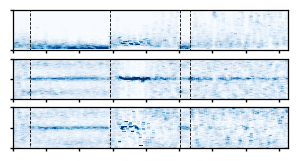

In [80]:
fig

# Panel B

In [81]:
fight_bout_info

array([[     0, 643500, 805400, 161900],
       [     1, 493700, 655400, 161700],
       [     2,  31500, 175400, 143900],
       [     3, 331300, 436400, 105100],
       [     5, 448500, 559400, 110900],
       [     7, 505500, 553400,  47900],
       [     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700],
       [    10,  19700,  79400,  59700],
       [    11, 214900, 280400,  65500],
       [    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900],
       [    13, 694500, 745600,  51100],
       [    14,   7700,  61800,  54100],
       [    15,  13500, 184400, 170900],
       [    18, 388700, 556400, 167700],
       [    19, 526700, 571200,  44500],
       [    20,  40900, 169600, 128700]])

In [82]:
fight_bout_info_noDurThresh

array([[     0, 385500, 427400,  41900],
       [     0, 583500, 610400,  26900],
       [     0, 643500, 805400, 161900],
       [     1, 274500, 301400,  26900],
       [     1, 385700, 409400,  23700],
       [     1, 493700, 655400, 161700],
       [     1, 700700, 718600,  17900],
       [     2,  31500, 175400, 143900],
       [     2, 301300, 319600,  18300],
       [     3, 331300, 436400, 105100],
       [     5, 448500, 559400, 110900],
       [     6, 217700, 250400,  32700],
       [     7,  91500, 127400,  35900],
       [     7, 505500, 553400,  47900],
       [     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700],
       [     8, 352500, 370400,  17900],
       [    10,  19700,  79400,  59700],
       [    11, 214900, 280400,  65500],
       [    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900],
       [    12, 358500, 385400,  26900],
       [    13, 694500, 745600,  51100],
       [    14,   7700,  61800,  54100],
       [    15, 

In [83]:
figure_bout_info = np.copy(fight_bout_info_noDurThresh)

numBouts = figure_bout_info.shape[0]
numBouts

33

In [84]:
# the set of expIdxs that have contributions to figure_bout_info
chosen_expIdxs = np.unique(figure_bout_info[:,0])
chosen_expIdxs

array([ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 17, 18, 19,
       20])

## gather state variables conditioned on fight/non-fight

In [85]:
# ---- prepare the nonfight regions ----#
# based on 'figure_bout_info'

chosen_expIdx_nonFight_regions = []

for expIdx in chosen_expIdxs:
    expName = expNames[expIdx]
    
    # find the bouts for this exp
    fight_epoch_array_rows = np.where(figure_bout_info[:,0] == expIdx)[0]
    
    # turn into list format over bouts, data is (startFrame,stopFrame)
    exp_fight_bout_lims_list = []
    for rowIdx in fight_epoch_array_rows:
        fight_bout_lims = figure_bout_info[rowIdx,1:3]
        exp_fight_bout_lims_list.append(fight_bout_lims)
        
    # now, prepare a binary timeseries of fight/non-fight membership for all frames,
    # recording all fights as truth
    expnfs = expNumFrames[expIdx]
    exp_fightFrame_bin_arr = np.zeros((expnfs,), dtype=bool)
    for bIdx in range(len(exp_fight_bout_lims_list)):
        exp_fightFrame_bin_arr[ exp_fight_bout_lims_list[bIdx][0]:exp_fight_bout_lims_list[bIdx][1]] = True
        
    # now find contiguous regions of the inverse of this array, 
    # giving us frame ranges where the fish are not fighting
    exp_non_fight_regions = contiguous_regions(~exp_fightFrame_bin_arr)
    
    # record
    chosen_expIdx_nonFight_regions.append([expIdx, exp_non_fight_regions])


In [86]:
# ----- get all fight state vars ---- #


master_fight_dpps = []
master_fight_tetWs = []
master_fight_tetLs = []

for boutIdx in range(numBouts):
    
    expIdx, f0, fE, bout_duration = figure_bout_info[boutIdx]
    
    bout_dpp = np.copy( exp_dpps[expIdx][f0:fE] )
    bout_tetW = np.copy( exp_tetWs[expIdx][f0:fE] )
    bout_tetL = np.copy( exp_tetLs[expIdx][f0:fE] )
    
    master_fight_dpps.append(bout_dpp)
    master_fight_tetWs.append(bout_tetW)
    master_fight_tetLs.append(bout_tetL)
    
# concatenate the results
master_fight_dpps = np.concatenate(master_fight_dpps)
master_fight_tetWs = np.concatenate(master_fight_tetWs)
master_fight_tetLs = np.concatenate(master_fight_tetLs)
    


In [87]:
# ---- get all non-fight state vars ---- #


master_nonfight_dpps = []
master_nonfight_tetWs = []
master_nonfight_tetLs = []

for exp_non_fight_regions in chosen_expIdx_nonFight_regions:
    
    expIdx = exp_non_fight_regions[0]
    nonBoutInfoArr = exp_non_fight_regions[1]
    
    exp_num_nonBout_epochs = nonBoutInfoArr.shape[0]
    for nBIdx in range(exp_num_nonBout_epochs):
        
        # get the data for this non-bout epoch
        f0,fE = nonBoutInfoArr[nBIdx]
        nonBout_dpp =  np.copy( exp_dpps[expIdx][f0:fE] )
        nonBout_tetW = np.copy( exp_tetWs[expIdx][f0:fE] )
        nonBout_tetL = np.copy( exp_tetLs[expIdx][f0:fE] )
        
        # record
        master_nonfight_dpps.append(nonBout_dpp)
        master_nonfight_tetWs.append(nonBout_tetW)
        master_nonfight_tetLs.append(nonBout_tetL)
        
# concatenate the results
master_nonfight_dpps = np.concatenate(master_nonfight_dpps)
master_nonfight_tetWs = np.concatenate(master_nonfight_tetWs)
master_nonfight_tetLs = np.concatenate(master_nonfight_tetLs)

In [88]:
master_fight_dpps.shape

(2188300,)

In [89]:
master_nonfight_dpps.shape

(10944574,)

## thetas

### top panel: during fights

In [126]:
x_data = np.copy(master_fight_tetWs)
y_data = np.copy(master_fight_tetLs)

theta_spatial_bins = np.linspace(-np.pi, np.pi, 20)

# now get the distributions of this data
theta_1_counts, _ = np.histogram(x_data, bins=theta_spatial_bins, density=True)
theta_1_prob = theta_1_counts / np.sum(theta_1_counts)
    
theta_2_counts, _ = np.histogram(y_data, bins=theta_spatial_bins, density=True)
theta_2_prob = theta_2_counts / np.sum(theta_2_counts)

In [127]:
np.sum(theta_1_prob)

0.9999999999999998

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
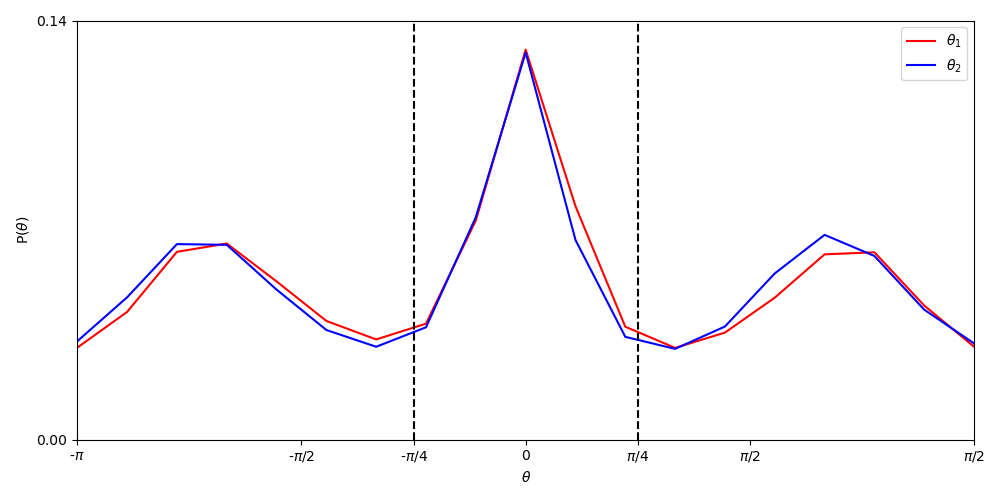

In [128]:
fig, axs = plt.subplots(figsize=(10,5))


# --- plot the theta distributions --- #
ax = axs
ax.set_title('')

ax.plot(theta_1_prob, color='red', label=r'$\theta_{1}$')
ax.plot(theta_2_prob, color='blue', label=r'$\theta_{2}$')


max_val = theta_2_prob.shape[0] - 1
xticks = [0, max_val*0.25, max_val*0.375, max_val*0.5, max_val*0.625, max_val*.75, max_val]
ax.set_xticks(xticks)
xticklabels = [r'-$\pi$', r'-$\pi/2$', r'-$\pi/4$', '0', r'$\pi/4$', r'$\pi/2$', r'$\pi/2$']
ax.set_xticklabels(xticklabels)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_xlabel(r'$\theta$')

ax.set_ylabel(r'P($\theta$)')
ax.set_ylim(bottom=0, top=0.14)
ax.set_yticks([0, 0.14])


# draw the verticle lines
ax.axvline(max_val*0.375, linestyle='--', color='black')
ax.axvline(max_val*0.625, linestyle='--', color='black')



ax.legend()


fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
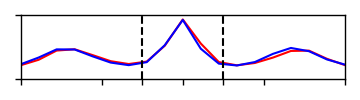

In [129]:
fig, axs = plt.subplots(figsize=(3.6, 1))

imsavepath = '/home/liam/temp/image_transfer/figure3_B_thetaFight.png'


# --- plot the theta distributions --- #
ax = axs
ax.set_title('')

ax.plot(theta_1_prob, color='red', label=r'$\theta_{1}$')
ax.plot(theta_2_prob, color='blue', label=r'$\theta_{2}$')


max_val = theta_2_prob.shape[0] - 1
xticks = [0, max_val*0.25, max_val*0.375, max_val*0.5, max_val*0.625, max_val*.75, max_val]
ax.set_xticks(xticks)
xticklabels = [r'-$\pi$', r'-$\pi/2$', r'-$\pi/4$', '0', r'$\pi/4$', r'$\pi/2$', r'$\pi/2$']
ax.set_xticklabels([])
ax.set_xlim(xticks[0], xticks[-1])
ax.set_xlabel('')

ax.set_ylabel('')
ax.set_ylim(bottom=0, top=0.14)
ax.set_yticks([0, 0.14])
ax.set_yticklabels([])


# draw the verticle lines
ax.axvline(max_val*0.375, linestyle='--', color='black')
ax.axvline(max_val*0.625, linestyle='--', color='black')


ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)


fig.tight_layout()

fig.savefig(imsavepath, transparent=True, dpi=300)

#### resized

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
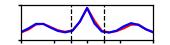

In [131]:
fig, axs = plt.subplots(figsize=(1.7, 0.45))

imsavepath = '/home/liam/temp/image_transfer/figure3_B_thetaFight.png'


# --- plot the theta distributions --- #
ax = axs
ax.set_title('')

ax.plot(theta_1_prob, color='red', label=r'$\theta_{1}$')
ax.plot(theta_2_prob, color='blue', label=r'$\theta_{2}$')


max_val = theta_2_prob.shape[0] - 1
xticks = [0, max_val*0.25, max_val*0.375, max_val*0.5, max_val*0.625, max_val*.75, max_val]
ax.set_xticks(xticks)
xticklabels = [r'-$\pi$', r'-$\pi/2$', r'-$\pi/4$', '0', r'$\pi/4$', r'$\pi/2$', r'$\pi/2$']
ax.set_xticklabels([])
ax.set_xlim(xticks[0], xticks[-1])
ax.set_xlabel('')

ax.set_ylabel('')
ax.set_ylim(bottom=0, top=0.14)
ax.set_yticks([0, 0.14])
ax.set_yticklabels([])


# draw the verticle lines
ax.axvline(max_val*0.375, linestyle='--', linewidth=0.9, color='black')
ax.axvline(max_val*0.625, linestyle='--', linewidth=0.9, color='black')


ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.9)


#fig.tight_layout()

fig.savefig(imsavepath, transparent=True, dpi=900)

### bottom panel: non-fights

In [132]:
x_data = np.copy(master_nonfight_tetWs)
y_data = np.copy(master_nonfight_tetLs)

theta_spatial_bins = np.linspace(-np.pi, np.pi, 20)

# now get the distributions of this data
theta_1_counts, _ = np.histogram(x_data, bins=theta_spatial_bins, density=True)
theta_1_prob = theta_1_counts / np.sum(theta_1_counts)
    
theta_2_counts, _ = np.histogram(y_data, bins=theta_spatial_bins, density=True)
theta_2_prob = theta_2_counts / np.sum(theta_2_counts)

In [133]:
np.sum(theta_1_prob)

1.0

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
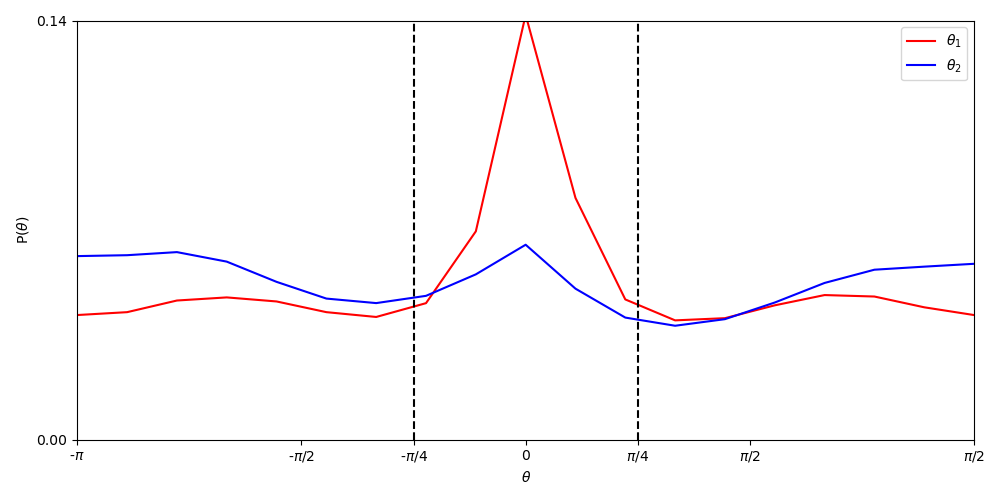

In [134]:
fig, axs = plt.subplots(figsize=(10,5))


# --- plot the theta distributions --- #
ax = axs
ax.set_title('')

ax.plot(theta_1_prob, color='red', label=r'$\theta_{1}$')
ax.plot(theta_2_prob, color='blue', label=r'$\theta_{2}$')


max_val = theta_2_prob.shape[0] - 1
xticks = [0, max_val*0.25, max_val*0.375, max_val*0.5, max_val*0.625, max_val*.75, max_val]
ax.set_xticks(xticks)
xticklabels = [r'-$\pi$', r'-$\pi/2$', r'-$\pi/4$', '0', r'$\pi/4$', r'$\pi/2$', r'$\pi/2$']
ax.set_xticklabels(xticklabels)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_xlabel(r'$\theta$')

ax.set_ylabel(r'P($\theta$)')
ax.set_ylim(bottom=0, top=0.14)
ax.set_yticks([0, 0.14])


# draw the verticle lines
ax.axvline(max_val*0.375, linestyle='--', color='black')
ax.axvline(max_val*0.625, linestyle='--', color='black')



ax.legend()


fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
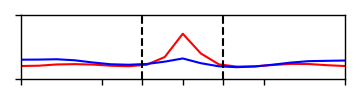

In [135]:
fig, axs = plt.subplots(figsize=(3.6, 1))

imsavepath = '/home/liam/temp/image_transfer/figure3_B_thetanonFight.png'


# --- plot the theta distributions --- #
ax = axs
ax.set_title('')

ax.plot(theta_1_prob, color='red', label=r'$\theta_{1}$')
ax.plot(theta_2_prob, color='blue', label=r'$\theta_{2}$')


max_val = theta_2_prob.shape[0] - 1
xticks = [0, max_val*0.25, max_val*0.375, max_val*0.5, max_val*0.625, max_val*.75, max_val]
ax.set_xticks(xticks)
xticklabels = [r'-$\pi$', r'-$\pi/2$', r'-$\pi/4$', '0', r'$\pi/4$', r'$\pi/2$', r'$\pi/2$']
ax.set_xticklabels([])
ax.set_xlim(xticks[0], xticks[-1])
ax.set_xlabel('')

ax.set_ylabel('')
ax.set_ylim(bottom=0, top=0.20)
ax.set_yticks([0, 0.20])
ax.set_yticklabels([])


# draw the verticle lines
ax.axvline(max_val*0.375, linestyle='--', color='black')
ax.axvline(max_val*0.625, linestyle='--', color='black')


ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)


fig.tight_layout()

fig.savefig(imsavepath, transparent=True, dpi=300)

#### resized

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
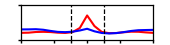

In [137]:
fig, axs = plt.subplots(figsize=(1.7, 0.45))

imsavepath = '/home/liam/temp/image_transfer/figure3_B_thetanonFight.png'


# --- plot the theta distributions --- #
ax = axs
ax.set_title('')

ax.plot(theta_1_prob, color='red', label=r'$\theta_{1}$')
ax.plot(theta_2_prob, color='blue', label=r'$\theta_{2}$')


max_val = theta_2_prob.shape[0] - 1
xticks = [0, max_val*0.25, max_val*0.375, max_val*0.5, max_val*0.625, max_val*.75, max_val]
ax.set_xticks(xticks)
xticklabels = [r'-$\pi$', r'-$\pi/2$', r'-$\pi/4$', '0', r'$\pi/4$', r'$\pi/2$', r'$\pi/2$']
ax.set_xticklabels([])
ax.set_xlim(xticks[0], xticks[-1])
ax.set_xlabel('')

ax.set_ylabel('')
ax.set_ylim(bottom=0, top=0.20)
ax.set_yticks([0, 0.20])
ax.set_yticklabels([])


# draw the verticle lines
ax.axvline(max_val*0.375, linestyle='--', linewidth=0.9, color='black')
ax.axvline(max_val*0.625, linestyle='--', linewidth=0.9, color='black')


ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.9)


#fig.tight_layout()

fig.savefig(imsavepath, transparent=True, dpi=900)

## dpp

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
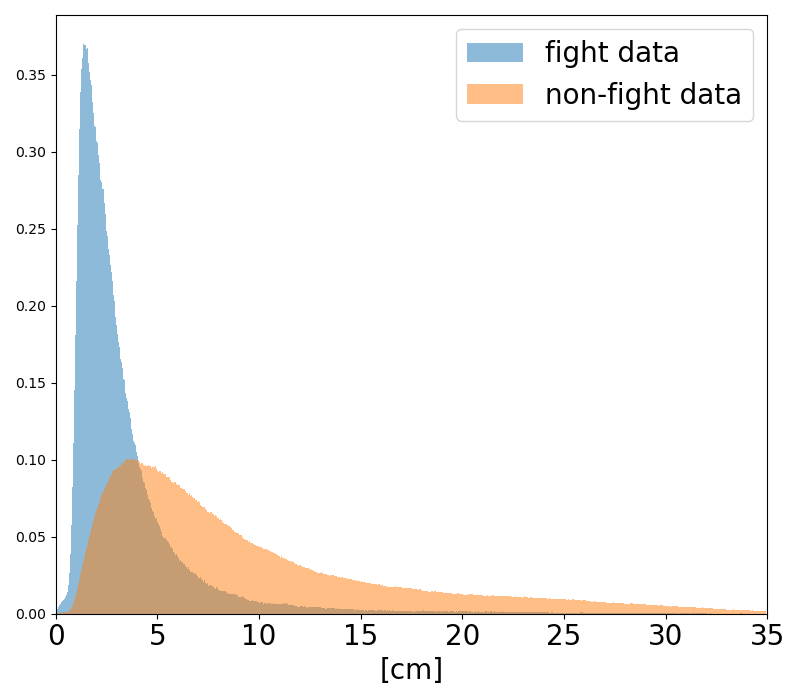

In [98]:
fig, axs = plt.subplots(figsize=(8,7))
ax = axs

ax.set_title('')
fight_hist_out = ax.hist(master_fight_dpps, bins=np.arange(0, 35, 0.05), density=True, alpha=0.5, label='fight data')
nonfight_hist_out = ax.hist(master_nonfight_dpps, bins=np.arange(0, 35, 0.05), density=True, alpha=0.5, label='non-fight data')
ax.set_xlim(0, 35)
ax.set_xticks([i*5 for i in range(8)])
ax.set_xticklabels(labels=[str(i*5) for i in range(8)], fontsize=20)
ax.set_xlabel('[cm]', fontsize=20)
#ax.set_yticklabels([])
fig.tight_layout()
ax.legend(fontsize=20)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
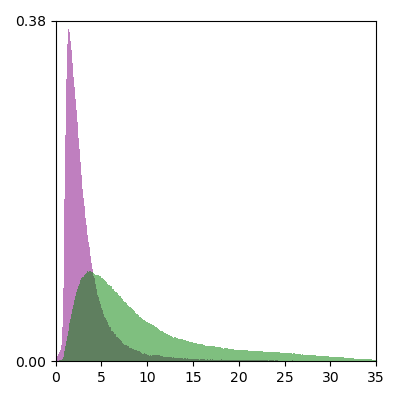

In [100]:
fig, axs = plt.subplots(figsize=(4,4))
ax = axs

#imsavepath = '/home/liam/temp/image_transfer/figure_3_panelB_dpp.png'

ax.set_title('')

bin_width = 0.05
fight_hist_out = ax.hist(master_fight_dpps, bins=np.arange(0, 35, bin_width), density=True, alpha=0.5, color='purple')
nonfight_hist_out = ax.hist(master_nonfight_dpps, bins=np.arange(0, 35, bin_width), density=True, alpha=0.5, color='green')

ax.set_xlim(0, 35)
ax.set_ylim(0, 0.38)

ax.set_xticks([i*5 for i in range(8)])
#ax.set_xticklabels([])
ax.set_xlabel('', fontsize=20)

#ax.set_yticklabels([])
# yticks
ax.set_yticks([0, 0.38])

fig.tight_layout()
#ax.legend(fontsize=20, labelspacing=3, borderpad=1.5)
#fig.savefig(imsavepath, dpi=300, transparent=True)

In [101]:
np.sum(fight_hist_out[0]) *bin_width

1.0

In [102]:
0.38*bin_width

0.019000000000000003

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
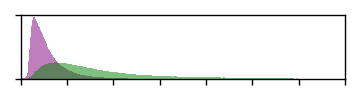

In [103]:
fig, axs = plt.subplots(figsize=(3.6,1))
ax = axs

imsavepath = '/home/liam/temp/image_transfer/figure3_B_dpp.png'

ax.set_title('')

bin_width = 0.05
fight_hist_out = ax.hist(master_fight_dpps, bins=np.arange(0, 35, bin_width), density=True, alpha=0.5, color='purple')
nonfight_hist_out = ax.hist(master_nonfight_dpps, bins=np.arange(0, 35, bin_width), density=True, alpha=0.5, color='green')

ax.set_xlim(0, 35)
ax.set_ylim(0, 0.38)

# axes labels
ax.set_xlabel('')
ax.set_ylabel('')

# xticks
ax.set_xticks([i*5 for i in range(8)])
ax.set_xticklabels([])

# yticks
ax.set_yticks([0, 0.38])
ax.set_yticklabels([])


ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)


fig.tight_layout()
#ax.legend(fontsize=20, labelspacing=3, borderpad=1.5)
fig.savefig(imsavepath, dpi=300, transparent=True)

### dpp resized

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
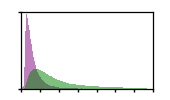

In [130]:
fig, axs = plt.subplots(figsize=(1.7,1))
ax = axs

imsavepath = '/home/liam/temp/image_transfer/figure3_B_dpp.png'

ax.set_title('')

bin_width = 0.05
fight_hist_out = ax.hist(master_fight_dpps, bins=np.arange(0, 35, bin_width), density=True, alpha=0.5, color='purple')
nonfight_hist_out = ax.hist(master_nonfight_dpps, bins=np.arange(0, 35, bin_width), density=True, alpha=0.5, color='green')

ax.set_xlim(0, 35)
ax.set_ylim(0, 0.38)

# axes labels
ax.set_xlabel('')
ax.set_ylabel('')

# xticks
ax.set_xticks([i*5 for i in range(8)])
ax.set_xticklabels([])

# yticks
ax.set_yticks([0, 0.38])
ax.set_yticklabels([])


ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.9)


#fig.tight_layout()
#ax.legend(fontsize=20, labelspacing=3, borderpad=1.5)
fig.savefig(imsavepath, dpi=900, transparent=True)

# Panel C

In this figure, we want to only use fights longer than 7 mins (like figure7), <br>
so we use the appropriate fight boundaries

In [6]:
figure_bout_info = np.copy(fight_bout_info)

numBouts = figure_bout_info.shape[0]
numBouts

18

In [7]:
figure_bout_info

array([[     0, 643500, 805400, 161900],
       [     1, 493700, 655400, 161700],
       [     2,  31500, 175400, 143900],
       [     3, 331300, 436400, 105100],
       [     5, 448500, 559400, 110900],
       [     7, 505500, 553400,  47900],
       [     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700],
       [    10,  19700,  79400,  59700],
       [    11, 214900, 280400,  65500],
       [    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900],
       [    13, 694500, 745600,  51100],
       [    14,   7700,  61800,  54100],
       [    15,  13500, 184400, 170900],
       [    18, 388700, 556400, 167700],
       [    19, 526700, 571200,  44500],
       [    20,  40900, 169600, 128700]])

In [8]:
frameGap = 30000 # the number of frames either side of the start and stops

In [9]:
# ----------------- Get the 4 frame ranges for each bout ------------------------#
#
# We will get the start&stop frame for each bout for each of these 4 regions
#
#
#       <---- nofight---><----fight----><------nofight---->
#      ------------|---()---|------|---()---|----------------
#                  <1>   <2>       <3>   <4>
#
# <1> = pre fight start
# <2> = post fight start
# <3> = pre fight end
# <4> = post fight end


pre_fight_begins_start_stops = np.zeros((numBouts, 2), dtype=int)
post_fight_begins_start_stops = np.zeros((numBouts, 2), dtype=int)

pre_fight_ends_start_stops = np.zeros((numBouts, 2), dtype=int)
post_fight_ends_start_stops = np.zeros((numBouts, 2), dtype=int)


for boutIdx in range(numBouts):
    
    # parse the info for this bout
    expIdx, fight_begin, fight_end, _ = figure_bout_info[boutIdx]
    #print(expIdx, fight_start, fight_stop)
    
    # record the 4 time-windows required from this bout
    
    pre_fight_begins_start_stops[boutIdx,0] = fight_begin - frameGap
    pre_fight_begins_start_stops[boutIdx,1] = fight_begin
    
    post_fight_begins_start_stops[boutIdx,0] = fight_begin
    post_fight_begins_start_stops[boutIdx,1] = fight_begin + frameGap
    
    pre_fight_ends_start_stops[boutIdx,0] = fight_end - frameGap
    pre_fight_ends_start_stops[boutIdx,1] = fight_end
    
    post_fight_ends_start_stops[boutIdx,0] = fight_end
    post_fight_ends_start_stops[boutIdx,1] = fight_end + frameGap
    

In [10]:
# ----------------- Use these 4 frame ranges to grab the data  ------------------------#

#1
pre_fight_begins_thetaW_list = []
pre_fight_begins_thetaL_list = []

#2
post_fight_begins_thetaW_list = []
post_fight_begins_thetaL_list = []

#3
pre_fight_ends_thetaW_list = []
pre_fight_ends_thetaL_list = []

#4
post_fight_ends_thetaW_list = []
post_fight_ends_thetaL_list = []


excluded_pre_begin_boutIdxs = []

for boutIdx in range(numBouts):
    
    # get the state vars for the experiment this bout comes from
    expIdx, fight_begin, fight_end, _ = figure_bout_info[boutIdx]
    exp_tetW = exp_tetWs[expIdx]
    exp_tetL = exp_tetLs[expIdx]

    # get the 4 frame ranges for this bout
    pre_begin_f0, pre_begin_fE = pre_fight_begins_start_stops[boutIdx]
    post_begin_f0, post_begin_fE = post_fight_begins_start_stops[boutIdx]
    pre_end_f0, pre_end_fE = pre_fight_ends_start_stops[boutIdx]
    post_end_f0, post_end_fE = post_fight_ends_start_stops[boutIdx]
    
    
    # deal with the starts first, where we might hit against the start of the experiment.
    # In this case we cant get enough frames, so we will exclude these experiments
    if pre_begin_f0 <= 0:
        excluded_pre_begin_boutIdxs.append(boutIdx)
        
        # 1 edge case to skip
        #pre_fight_begins_thetaW_list
        #pre_fight_begins_thetaL_list
        
        # 3 regular cases
        post_fight_begins_thetaW_list.append( np.copy(exp_tetW[post_begin_f0:post_begin_fE]) )
        post_fight_begins_thetaL_list.append( np.copy(exp_tetL[post_begin_f0:post_begin_fE]) )

        pre_fight_ends_thetaW_list.append( np.copy(exp_tetW[pre_end_f0:pre_end_fE]) )
        pre_fight_ends_thetaL_list.append( np.copy(exp_tetL[pre_end_f0:pre_end_fE]) )

        post_fight_ends_thetaW_list.append( np.copy(exp_tetW[post_end_f0:post_end_fE]) )
        post_fight_ends_thetaL_list.append( np.copy(exp_tetL[post_end_f0:post_end_fE]) )
        
    else:
        # 4 regular cases
        pre_fight_begins_thetaW_list.append( np.copy(exp_tetW[pre_begin_f0:pre_begin_fE]) )
        pre_fight_begins_thetaL_list.append( np.copy(exp_tetL[pre_begin_f0:pre_begin_fE]) )

        post_fight_begins_thetaW_list.append( np.copy(exp_tetW[post_begin_f0:post_begin_fE]) )
        post_fight_begins_thetaL_list.append( np.copy(exp_tetL[post_begin_f0:post_begin_fE]) )

        pre_fight_ends_thetaW_list.append( np.copy(exp_tetW[pre_end_f0:pre_end_fE]) )
        pre_fight_ends_thetaL_list.append( np.copy(exp_tetL[pre_end_f0:pre_end_fE]) )

        post_fight_ends_thetaW_list.append( np.copy(exp_tetW[post_end_f0:post_end_fE]) )
        post_fight_ends_thetaL_list.append( np.copy(exp_tetL[post_end_f0:post_end_fE]) )


        
# convert to arrays

#1
pre_fight_begins_thetaW_arr = np.stack(pre_fight_begins_thetaW_list, axis=0)
pre_fight_begins_thetaL_arr = np.stack(pre_fight_begins_thetaL_list, axis=0)

#2
post_fight_begins_thetaW_arr = np.stack(post_fight_begins_thetaW_list, axis=0)
post_fight_begins_thetaL_arr = np.stack(post_fight_begins_thetaL_list, axis=0)

#3
pre_fight_ends_thetaW_arr = np.stack(pre_fight_ends_thetaW_list, axis=0)
pre_fight_ends_thetaL_arr = np.stack(pre_fight_ends_thetaL_list, axis=0)

#4
post_fight_ends_thetaW_arr= np.stack(post_fight_ends_thetaW_list, axis=0)
post_fight_ends_thetaL_arr = np.stack(post_fight_ends_thetaL_list, axis=0)



print(pre_fight_begins_thetaW_arr.shape, pre_fight_begins_thetaL_arr.shape)
print(post_fight_begins_thetaW_arr.shape)
print(pre_fight_ends_thetaW_arr.shape)
print(post_fight_ends_thetaW_arr.shape)


(15, 30000) (15, 30000)
(18, 30000)
(18, 30000)
(18, 30000)


In [11]:
# ---- Getting windowed probabilities distributions ---- #

# we have the timeseries of thetaW and thetaL for (frameGap/6000) mins pre and post fight end and start for multiple fights.
# now for each experiment, I want to estimate the distributions in running windows 


period_numFrames = frameGap
window_size=6000
window_step=100
fight_avg_time_windows = return_overlapping_windows_for_timeframes(period_numFrames,
                                                                   window_size=window_size,
                                                                   window_step=window_step)


theta_spatial_bins = np.linspace(-np.pi, np.pi, 20)

num_computed_dists = fight_avg_time_windows.shape[0]




# Get the windowed distributions

tetW_pre_begin_dists = []
tetL_pre_begin_dists = []

tetW_post_begin_dists = []
tetL_post_begin_dists = []

tetW_pre_end_dists = []
tetL_pre_end_dists = []

tetW_post_end_dists = []
tetL_post_end_dists = []

for boutIdx in range(numBouts):    
    #2
    tet_tseries = post_fight_begins_thetaW_arr[boutIdx]
    dist = compute_windowed_distribution_array_from_1D_tseries(tet_tseries, fight_avg_time_windows, theta_spatial_bins)
    #dist[:, np.where(np.sum(dist,axis=0)==0)[0]] = np.NaN
    tetW_post_begin_dists.append(dist)
    
    tet_tseries = post_fight_begins_thetaL_arr[boutIdx]
    dist = compute_windowed_distribution_array_from_1D_tseries(tet_tseries, fight_avg_time_windows, theta_spatial_bins)
    #dist[:, np.where(np.sum(dist,axis=0)==0)[0]] = np.NaN
    tetL_post_begin_dists.append(dist)
    
    #3
    tet_tseries = pre_fight_ends_thetaW_arr[boutIdx]
    dist = compute_windowed_distribution_array_from_1D_tseries(tet_tseries, fight_avg_time_windows, theta_spatial_bins)
    #dist[:, np.where(np.sum(dist,axis=0)==0)[0]] = np.NaN
    tetW_pre_end_dists.append(dist)
    
    tet_tseries = pre_fight_ends_thetaL_arr[boutIdx]
    dist = compute_windowed_distribution_array_from_1D_tseries(tet_tseries, fight_avg_time_windows, theta_spatial_bins)
    #dist[:, np.where(np.sum(dist,axis=0)==0)[0]] = np.NaN
    tetL_pre_end_dists.append(dist)
    
    #4
    tet_tseries = post_fight_ends_thetaW_arr[boutIdx]
    dist = compute_windowed_distribution_array_from_1D_tseries(tet_tseries, fight_avg_time_windows, theta_spatial_bins)
    #dist[:, np.where(np.sum(dist,axis=0)==0)[0]] = np.NaN
    tetW_post_end_dists.append(dist)
    
    tet_tseries = post_fight_ends_thetaL_arr[boutIdx]
    dist = compute_windowed_distribution_array_from_1D_tseries(tet_tseries, fight_avg_time_windows, theta_spatial_bins)
    #dist[:, np.where(np.sum(dist,axis=0)==0)[0]] = np.NaN
    tetL_post_end_dists.append(dist)
    
    
# do this separately, as we have less bouts
for boutIdx in range(pre_fight_begins_thetaW_arr.shape[0]):
    #1
    tet_tseries = pre_fight_begins_thetaW_arr[boutIdx]
    dist = compute_windowed_distribution_array_from_1D_tseries(tet_tseries, fight_avg_time_windows, theta_spatial_bins)
    #dist[:, np.where(np.sum(dist,axis=0)==0)[0]] = np.NaN
    tetW_pre_begin_dists.append(dist)
    
    tet_tseries = pre_fight_begins_thetaL_arr[boutIdx]
    dist = compute_windowed_distribution_array_from_1D_tseries(tet_tseries, fight_avg_time_windows, theta_spatial_bins)
    #dist[:, np.where(np.sum(dist,axis=0)==0)[0]] = np.NaN
    tetL_pre_begin_dists.append(dist)
    
    
    
# convert to arrays
tetW_pre_begin_dists = np.stack(tetW_pre_begin_dists, axis=0)
tetL_pre_begin_dists = np.stack(tetL_pre_begin_dists, axis=0)

tetW_post_begin_dists = np.stack(tetW_post_begin_dists, axis=0)
tetL_post_begin_dists = np.stack(tetL_post_begin_dists, axis=0)

tetW_pre_end_dists = np.stack(tetW_pre_end_dists, axis=0)
tetL_pre_end_dists = np.stack(tetL_pre_end_dists, axis=0)

tetW_post_end_dists = np.stack(tetW_post_end_dists, axis=0)
tetL_post_end_dists = np.stack(tetL_post_end_dists, axis=0)
    
    
    
    
print(tetW_pre_begin_dists.shape,tetL_pre_begin_dists.shape)
print(tetW_post_begin_dists.shape)
print(tetW_pre_end_dists.shape)
print(tetW_post_end_dists.shape)

(15, 19, 240) (15, 19, 240)
(18, 19, 240)
(18, 19, 240)
(18, 19, 240)


In [12]:
# ----------------------- Compute the JSDs ------------------------------#
# take JS distance squared for JS divergence

t0 = time.perf_counter()

pre_begin_JSDs = np.zeros((tetW_pre_begin_dists.shape[0], tetW_pre_begin_dists.shape[2]))*np.NaN
for boutIdx in range(tetW_pre_begin_dists.shape[0]):
    bout_tetW_dists = tetW_pre_begin_dists[boutIdx]
    bout_tetL_dists = tetL_pre_begin_dists[boutIdx]
    for distIdx in range(bout_tetW_dists.shape[1]):
        tetW_dist =  bout_tetW_dists[:, distIdx] / np.sum(bout_tetW_dists[:, distIdx])
        tetL_dist =  bout_tetL_dists[:, distIdx] / np.sum(bout_tetL_dists[:, distIdx])
        tetW_tetL_js = ( distance.jensenshannon(tetW_dist, tetL_dist, base=2) )**2
        pre_begin_JSDs[boutIdx, distIdx] = tetW_tetL_js
        
        
post_begin_JSDs = np.zeros((tetW_post_begin_dists.shape[0], tetW_post_begin_dists.shape[2]))*np.NaN
for boutIdx in range(tetW_post_begin_dists.shape[0]):
    bout_tetW_dists = tetW_post_begin_dists[boutIdx]
    bout_tetL_dists = tetL_post_begin_dists[boutIdx]
    for distIdx in range(bout_tetW_dists.shape[1]):
        tetW_dist =  bout_tetW_dists[:, distIdx] / np.sum(bout_tetW_dists[:, distIdx])
        tetL_dist =  bout_tetL_dists[:, distIdx] / np.sum(bout_tetL_dists[:, distIdx])
        tetW_tetL_js = ( distance.jensenshannon(tetW_dist, tetL_dist, base=2) )**2
        post_begin_JSDs[boutIdx, distIdx] = tetW_tetL_js
        
        
pre_end_JSDs = np.zeros((tetW_pre_end_dists.shape[0], tetW_pre_end_dists.shape[2]))*np.NaN
for boutIdx in range(tetW_pre_end_dists.shape[0]):
    bout_tetW_dists = tetW_pre_end_dists[boutIdx]
    bout_tetL_dists = tetL_pre_end_dists[boutIdx]
    for distIdx in range(bout_tetW_dists.shape[1]):
        tetW_dist =  bout_tetW_dists[:, distIdx] / np.sum(bout_tetW_dists[:, distIdx])
        tetL_dist =  bout_tetL_dists[:, distIdx] / np.sum(bout_tetL_dists[:, distIdx])
        tetW_tetL_js = ( distance.jensenshannon(tetW_dist, tetL_dist, base=2) )**2
        pre_end_JSDs[boutIdx, distIdx] = tetW_tetL_js
        
        
post_end_JSDs = np.zeros((tetW_post_end_dists.shape[0], tetW_post_end_dists.shape[2]))*np.NaN
for boutIdx in range(tetW_post_end_dists.shape[0]):
    bout_tetW_dists = tetW_post_end_dists[boutIdx]
    bout_tetL_dists = tetL_post_end_dists[boutIdx]
    for distIdx in range(bout_tetW_dists.shape[1]):
        tetW_dist =  bout_tetW_dists[:, distIdx] / np.sum(bout_tetW_dists[:, distIdx])
        tetL_dist =  bout_tetL_dists[:, distIdx] / np.sum(bout_tetL_dists[:, distIdx])
        tetW_tetL_js = ( distance.jensenshannon(tetW_dist, tetL_dist, base=2) )**2
        post_end_JSDs[boutIdx, distIdx] = tetW_tetL_js
        
        
tE = time.perf_counter()
print(tE-t0)
print()
print('(numBouts,numWins)')
print(pre_begin_JSDs.shape)
print(post_begin_JSDs.shape)
print(pre_end_JSDs.shape)
print(post_end_JSDs.shape)

0.6295499615371227

(numBouts,numWins)
(15, 240)
(18, 240)
(18, 240)
(18, 240)


In [13]:
# ------------------ compute the mean across bouts ----------------------- #

pre_begin_JSDs_expMean = np.mean(pre_begin_JSDs, axis=0)
post_begin_JSDs_expMean = np.mean(post_begin_JSDs, axis=0)
pre_end_JSDs_expMean = np.mean(pre_end_JSDs, axis=0)
post_end_JSDs_expMean = np.mean(post_end_JSDs, axis=0)




In [14]:
pre_begin_JSDs_expMean.shape

(240,)

In [15]:
# ----------------------- bootstrap ------------------------------#
t0 = time.perf_counter()


# args
confidence_interval=95
n_resamples=100
per=(100-confidence_interval)/2

# the number of fight we bootstrap over
numSamples_list = [pre_begin_JSDs.shape[0], post_begin_JSDs.shape[0], pre_end_JSDs.shape[0], post_end_JSDs.shape[0]]


# preallocate some lists to hold results
resamples_pre_begin_mean_JSDs = []
resamples_post_begin_mean_JSDs = []
resamples_pre_end_mean_JSDs = []
resamples_post_end_mean_JSDs = []

#1
resamples_pre_begin_mean_JSDs = []
for i in range(n_resamples):
    # the number of bouts we have access to
    numSamples = pre_begin_JSDs.shape[0] 
    #  get the bout indices for this resample 
    indices=np.random.choice(range(0,numSamples), numSamples)
    # gather the data for these resampling
    sample_pre_begin_JSDs = np.zeros_like(pre_begin_JSDs)*np.NaN
    for idx,boutIdx in enumerate(indices):
        sample_pre_begin_JSDs[idx] = pre_begin_JSDs[boutIdx]
    # compute the sample-wise mean
    sample_pre_begin_JSDs_mean = np.mean(sample_pre_begin_JSDs, axis=0)
    # add this resample mean to the distribution of means we are building
    resamples_pre_begin_mean_JSDs.append(sample_pre_begin_JSDs_mean)
# combine to array shape (n_resamples, numWins)
resamples_pre_begin_mean_JSDs = np.stack(resamples_pre_begin_mean_JSDs, axis=0)
# get the standard deviation of distribution of means
bootstrap_std_pre_begin_JSDs = np.std(resamples_pre_begin_mean_JSDs, axis=0)


#2
resamples_post_begin_mean_JSDs = []
for i in range(n_resamples):
    # the number of bouts we have access to
    numSamples = post_begin_JSDs.shape[0] 
    #  get the bout indices for this resample 
    indices=np.random.choice(range(0,numSamples), numSamples)
    # gather the data for these resampling
    sample_post_begin_JSDs = np.zeros_like(post_begin_JSDs)*np.NaN
    for idx,boutIdx in enumerate(indices):
        sample_post_begin_JSDs[idx] = post_begin_JSDs[boutIdx]
    # compute the sample-wise mean
    sample_post_begin_JSDs_mean = np.mean(sample_post_begin_JSDs, axis=0)
    # add this resample mean to the distribution of means we are building
    resamples_post_begin_mean_JSDs.append(sample_post_begin_JSDs_mean)
# combine to array shape (n_resamples, numWins)
resamples_post_begin_mean_JSDs = np.stack(resamples_post_begin_mean_JSDs, axis=0)
# get the standard deviation of distribution of means
bootstrap_std_post_begin_JSDs = np.std(resamples_post_begin_mean_JSDs, axis=0)


#3
resamples_pre_end_mean_JSDs = []
for i in range(n_resamples):
    # the number of bouts we have access to
    numSamples =  pre_end_JSDs.shape[0] 
    #  get the bout indices for this resample 
    indices=np.random.choice(range(0,numSamples), numSamples)
    # gather the data for these resampling
    sample_pre_end_JSDs = np.zeros_like(pre_end_JSDs)*np.NaN
    for idx,boutIdx in enumerate(indices):
        sample_pre_end_JSDs[idx] = pre_end_JSDs[boutIdx]
    # compute the sample-wise mean
    sample_pre_end_JSDs_mean = np.mean(sample_pre_end_JSDs, axis=0)
    # add this resample mean to the distribution of means we are building
    resamples_pre_end_mean_JSDs.append(sample_pre_end_JSDs_mean)
# combine to array shape (n_resamples, numWins)
resamples_pre_end_mean_JSDs = np.stack(resamples_pre_end_mean_JSDs, axis=0)
# get the standard deviation of distribution of means
bootstrap_std_pre_end_JSDs = np.std(resamples_pre_end_mean_JSDs, axis=0)



#4
resamples_post_end_mean_JSDs = []
for i in range(n_resamples):
    # the number of bouts we have access to
    numSamples =  post_end_JSDs.shape[0]
    #  get the bout indices for this resample 
    indices=np.random.choice(range(0,numSamples), numSamples)
    # gather the data for these resampling
    sample_post_end_JSDs = np.zeros_like(post_end_JSDs)*np.NaN
    for idx,boutIdx in enumerate(indices):
        sample_post_end_JSDs[idx] = post_end_JSDs[boutIdx]
    # compute the sample-wise mean
    sample_post_end_JSDs_mean = np.mean(sample_post_end_JSDs, axis=0)
    # add this resample mean to the distribution of means we are building
    resamples_post_end_mean_JSDs.append(sample_post_end_JSDs_mean)
# combine to array shape (n_resamples, numWins)
resamples_post_end_mean_JSDs = np.stack(resamples_post_end_mean_JSDs, axis=0)
# get the standard deviation of distribution of means
bootstrap_std_post_end_JSDs = np.std(resamples_post_end_mean_JSDs, axis=0)

        
tE = time.perf_counter()
print(tE-t0)

0.04598000459372997


In [16]:
# concatenate into begins and ends

begin_JSDs_means = np.concatenate([pre_begin_JSDs_expMean, post_begin_JSDs_expMean])
end_JSDs_means = np.concatenate([pre_end_JSDs_expMean, post_end_JSDs_expMean])

begin_JSD_bootstrap_std = np.concatenate([bootstrap_std_pre_begin_JSDs, bootstrap_std_post_begin_JSDs])
end_JSD_bootstrap_std = np.concatenate([bootstrap_std_pre_end_JSDs, bootstrap_std_post_end_JSDs])

In [17]:
print(begin_JSDs_means.shape)
print(begin_JSD_bootstrap_std.shape)

(480,)
(480,)


In [18]:
print(end_JSDs_means.shape)
print(end_JSD_bootstrap_std.shape)

(480,)
(480,)


## plotting (rough)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
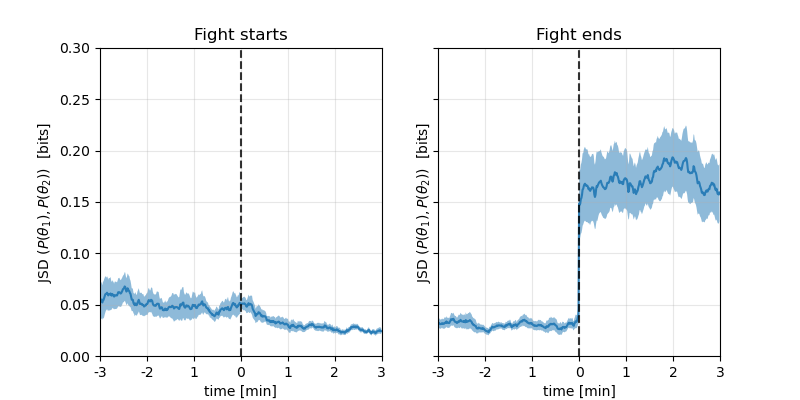

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4), sharey=True)


# ---- beginning panel ---- #
ax = axs[0]
ax.set_title('Fight starts')

# get where to draw the fight start line
total_num_wins = begin_JSDs_means.shape[0]
fight_start_win_idx = int(total_num_wins/2)

xvals = np.arange(0, total_num_wins)

# plot the true mean curve
ax.plot(xvals, begin_JSDs_means, color='C0', alpha=0.9)

# fill between the stdev lines
max_curve = begin_JSDs_means + begin_JSD_bootstrap_std
min_curve = begin_JSDs_means - begin_JSD_bootstrap_std
ax.fill_between(xvals, y1=min_curve, y2=max_curve, alpha=0.5)

ax.axvline(fight_start_win_idx, color='black', linestyle='--', alpha=0.8)
ax.set_xlim(0, total_num_wins)
ax.set_ylim(0, 0.3)
ax.set_ylabel('JSD ' + r'$(P(\theta_{1}),P(\theta_{2}))$' + '  [bits]')
ax.set_xlabel('time [min]')

xticks = [i*(total_num_wins/6) for i in range(7)]
ax.set_xticks(xticks );
xticklabels = ['-3', '-2', '1', '0', '1', '2', '3']
ax.set_xticklabels(xticklabels);
ax.grid(alpha=0.3)




# ---- end panel ---- #
ax = axs[1]
ax.set_title('Fight ends')

# get where to draw the fight start line
total_num_wins = end_JSDs_means.shape[0]
fight_start_win_idx = int(total_num_wins/2)

xvals = np.arange(0, total_num_wins)

# plot the true mean curve
ax.plot(xvals, end_JSDs_means, color='C0', alpha=0.9)

# fill between the stdev lines
max_curve = end_JSDs_means + end_JSD_bootstrap_std
min_curve = end_JSDs_means - end_JSD_bootstrap_std
ax.fill_between(xvals, y1=min_curve, y2=max_curve, alpha=0.5)

ax.axvline(fight_start_win_idx, color='black', linestyle='--', alpha=0.8)
ax.set_xlim(0, total_num_wins)
ax.set_ylim(0, 0.3)
ax.set_ylabel('JSD ' + r'$(P(\theta_{1}),P(\theta_{2}))$' + '  [bits]')
ax.set_xlabel('time [min]')

xticks = [i*(total_num_wins/6) for i in range(7)]
ax.set_xticks(xticks );
xticklabels = ['-3', '-2', '1', '0', '1', '2', '3']
ax.set_xticklabels(xticklabels);
ax.grid(alpha=0.3)

## paper version

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
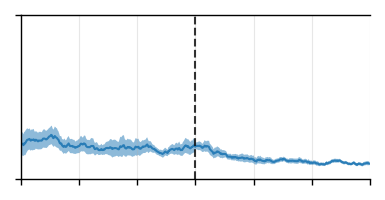

In [20]:
# ---- plot with labels ----- #

fig, axs = plt.subplots(ncols=1, figsize=(3.85,2), sharey=False)


# --starts --#

ax = axs

# get where to draw the fight end line
total_num_wins = begin_JSDs_means.shape[0]
fight_start_win_idx = int(total_num_wins/2)


xvals = np.arange(0, total_num_wins)

# plot the true mean curve
ax.plot(xvals, begin_JSDs_means, color='C0', alpha=0.9)

# fill between the stdev lines
max_curve = begin_JSDs_means + begin_JSD_bootstrap_std
min_curve = begin_JSDs_means - begin_JSD_bootstrap_std
ax.fill_between(xvals, y1=min_curve, y2=max_curve, alpha=0.5)


ax.axvline(fight_start_win_idx, color='black', linestyle='--', alpha=0.8)
ax.set_xlim(0, total_num_wins)
ax.set_ylim(0, 0.25)
ax.set_ylabel('')
ax.set_xlabel('')

xticks = [i*(total_num_wins/6) for i in range(7)]
ax.set_xticks(xticks );
xticklabels = ['-3', '-2', '1', '0', '1', '2', '3']
ax.set_xticklabels([]);
ax.grid(alpha=0.3)


ax.set_yticks([0, 0.25])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
for axis in ['right']:
    ax.spines[axis].set_visible(False)

fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/figure_3_panelC_starts.png'
fig.savefig(imsavepath, transparent=True, dpi=300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
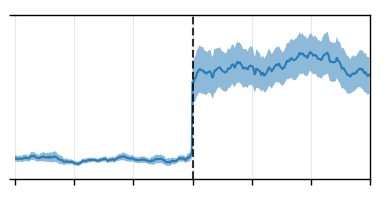

In [21]:
# ---- plot with labels ----- #

fig, axs = plt.subplots(ncols=1, figsize=(3.85,2), sharey=False)

#end_JSDs_means + end_JSD_bootstrap_std
# --starts --#

ax = axs

# get where to draw the fight end line
total_num_wins = end_JSDs_means.shape[0]
fight_end_win_idx = int(total_num_wins/2)


xvals = np.arange(0, total_num_wins)

# plot the true mean curve
ax.plot(xvals, end_JSDs_means, color='C0', alpha=0.9)

# fill between the stdev lines
max_curve = end_JSDs_means + end_JSD_bootstrap_std
min_curve = end_JSDs_means - end_JSD_bootstrap_std
ax.fill_between(xvals, y1=min_curve, y2=max_curve, alpha=0.5)


ax.axvline(fight_end_win_idx, color='black', linestyle='--', alpha=0.8)
ax.set_xlim(0, total_num_wins)
ax.set_ylim(0, 0.25)
ax.set_ylabel('')


xticks = [i*(total_num_wins/6) for i in range(7)]
ax.set_xticks(xticks );
xticklabels = ['-3', '-2', '1', '0', '1', '2', '3']
ax.set_xticklabels([]);
ax.grid(alpha=0.3)


ax.set_yticks([0, 0.25])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
for axis in ['left']:
    ax.spines[axis].set_visible(False)

fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/figure_3_panelC_ends.png'
fig.savefig(imsavepath, transparent=True, dpi=300)

## paper version resized

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
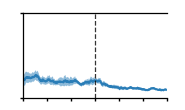

In [38]:
# ---- plot with labels ----- #

fig, axs = plt.subplots(ncols=1, figsize=(1.85, 1.1), sharey=False)


# --starts --#

ax = axs

# get where to draw the fight end line
total_num_wins = begin_JSDs_means.shape[0]
fight_start_win_idx = int(total_num_wins/2)


xvals = np.arange(0, total_num_wins)

# plot the true mean curve
ax.plot(xvals, begin_JSDs_means, color='C0', alpha=0.9)

# fill between the stdev lines
max_curve = begin_JSDs_means + begin_JSD_bootstrap_std
min_curve = begin_JSDs_means - begin_JSD_bootstrap_std
ax.fill_between(xvals, y1=min_curve, y2=max_curve, alpha=0.5)


ax.axvline(fight_start_win_idx, color='black', linestyle='--', linewidth=0.9, alpha=0.8)
ax.set_xlim(0, total_num_wins)
ax.set_ylim(0, 0.25)
ax.set_ylabel('')
ax.set_xlabel('')

xticks = [i*(total_num_wins/6) for i in range(7)]
ax.set_xticks(xticks );
xticklabels = ['-3', '-2', '1', '0', '1', '2', '3']
ax.set_xticklabels([]);
ax.grid(False)


ax.set_yticks([0, 0.25])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.9)
for axis in ['right']:
    ax.spines[axis].set_visible(False)

#fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/figure_3_panelC_starts.png'
fig.savefig(imsavepath, transparent=True, dpi=900)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
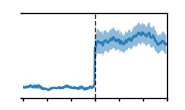

In [37]:
# ---- plot with labels ----- #

fig, axs = plt.subplots(ncols=1, figsize=(1.85, 1.1), sharey=False)

#end_JSDs_means + end_JSD_bootstrap_std
# --starts --#

ax = axs

# get where to draw the fight end line
total_num_wins = end_JSDs_means.shape[0]
fight_end_win_idx = int(total_num_wins/2)


xvals = np.arange(0, total_num_wins)

# plot the true mean curve
ax.plot(xvals, end_JSDs_means, color='C0', alpha=0.9)

# fill between the stdev lines
max_curve = end_JSDs_means + end_JSD_bootstrap_std
min_curve = end_JSDs_means - end_JSD_bootstrap_std
ax.fill_between(xvals, y1=min_curve, y2=max_curve, alpha=0.5)


ax.axvline(fight_end_win_idx, color='black', linestyle='--', linewidth=0.9, alpha=0.8)
ax.set_xlim(0, total_num_wins)
ax.set_ylim(0, 0.25)
ax.set_ylabel('')


xticks = [i*(total_num_wins/6) for i in range(7)]
ax.set_xticks(xticks );
xticklabels = ['-3', '-2', '1', '0', '1', '2', '3']
ax.set_xticklabels([]);
ax.grid(False)


ax.set_yticks([0, 0.25])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.9)
for axis in ['left']:
    ax.spines[axis].set_visible(False)

#fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/figure_3_panelC_ends.png'
fig.savefig(imsavepath, transparent=True, dpi=900)